In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
old = pd.read_table('isochrones/cmd_synt.13000.Fe-1.0.dat', skiprows = 4, header = None, sep = '\s+', usecols=[0,1])
old.head()

,0,1
0,4.71136,0.56505
1,3.94420,0.51366
2,1.41247,-0.05395
3,5.07772,0.61336
4,5.07172,0.60758


In [4]:
young = pd.read_table('isochrones/cmd_synt.3000.Fe-2.3.dat', skiprows = 4, header = None, sep = '\s+', usecols=[0,1])
young.head()

,0,1
0,4.33105,0.44937
1,3.31389,0.26715
2,2.16792,-0.12057
3,4.89255,0.53584
4,4.90654,0.53528


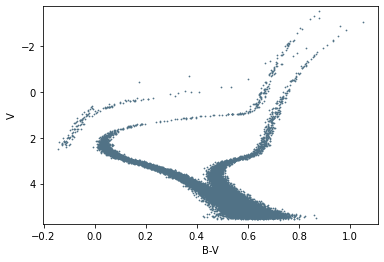

In [5]:
def plotCMD(cmd):
    color = cmd.iloc[:,1]
    magnitude = cmd.iloc[:,0]
    plt.scatter(color, magnitude, s = 0.5535, color = "#517286")
    plt.ylim([magnitude.max()+0.2, magnitude.min()-0.2])
    plt.xlabel("B-V")
    plt.ylabel("V")
    
plotCMD(old)
plotCMD(young)
plt.show()

In [6]:
def mix_CMDs(files, n_to_sample):
    cmd = None
    for f, n in zip(files, n_to_sample):
        if cmd is not None:
            newcmd = pd.read_table(f, skiprows = 4, header = None, sep = '\s+', usecols=[0,1])
            newcmd = newcmd.iloc[np.random.choice(range(newcmd.shape[0]), n),:]
            cmd = pd.concat([cmd, newcmd])
        if cmd is None:
            newcmd = pd.read_table(f, skiprows = 4, header = None, sep = '\s+', usecols=[0,1])
            cmd = newcmd.iloc[np.random.choice(range(newcmd.shape[0]), n),:]
    return cmd

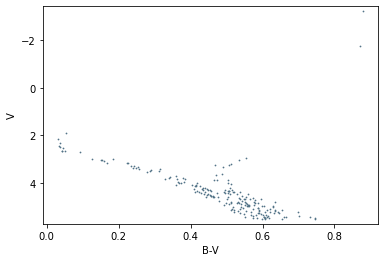

0.44392533303862053
0.4083107478376137


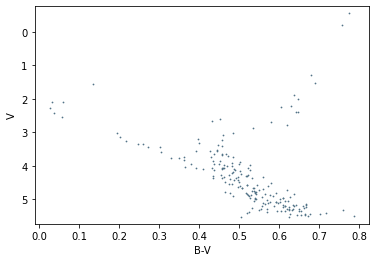

9.058939702254424
10.531404764866036


In [7]:
import mistree as mist #use pavia00
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore') #should understand instead

def sta(u):
    u = (u - np.median(u))/(np.quantile(u, 0.75) - np.quantile(u, 0.25))
    return u

somemix = mix_CMDs(['isochrones/cmd_synt.13000.Fe-1.0.dat', 'isochrones/cmd_synt.3000.Fe-2.3.dat'], [80, 120])
plotCMD(somemix)
plt.show()

x = sta(somemix.iloc[:,0].to_numpy())
y = sta(somemix.iloc[:,1].to_numpy())
mst = mist.GetMST(x=x, y=y)
d, l, b, s = mst.get_stats()
print(np.median(l)/np.quantile(l, 0.9)) #ratio of median edge length to 90th percentile edge length

someothermix = mix_CMDs(['isochrones/cmd_synt.13000.Fe-1.0.dat', 'isochrones/cmd_synt.11000.Fe-1.0.dat', 'isochrones/cmd_synt.7000.Fe-1.0.dat', 'isochrones/cmd_synt.3000.Fe-2.3.dat'], [40,60,55,45])
x = sta(someothermix.iloc[:,0].to_numpy())
y = sta(someothermix.iloc[:,1].to_numpy())
mst = mist.GetMST(x=x, y=y)
l_A = l
d, l, b, s = mst.get_stats()
l_B = l
print(np.median(l)/np.quantile(l, 0.9)) #ratio of median edge length to 90th percentile edge length

plotCMD(someothermix)
plt.show()

pairwise_distances_A = cdist(somemix.iloc[:,0:1], somemix.iloc[:,0:1])
print(pairwise_distances_A.mean()/l_A.mean())

pairwise_distances_B = cdist(someothermix.iloc[:,0:1], someothermix.iloc[:,0:1])
print(pairwise_distances_B.mean()/l_B.mean())


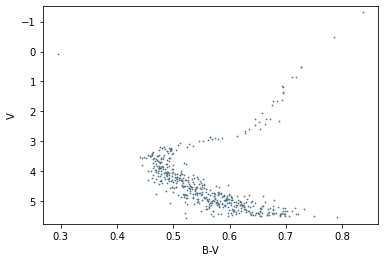

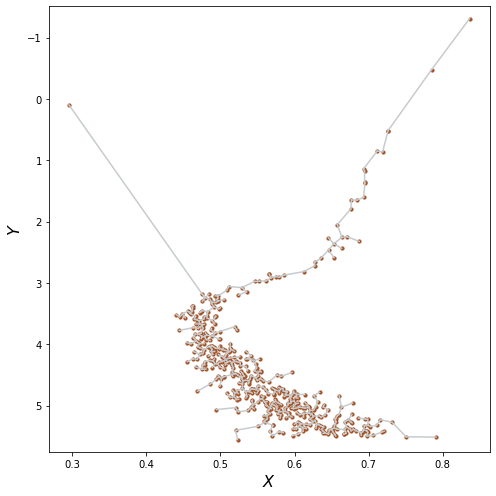

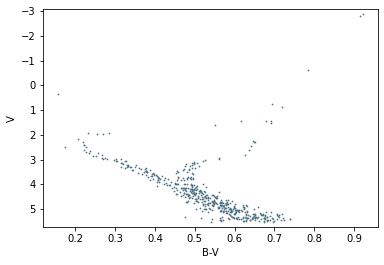

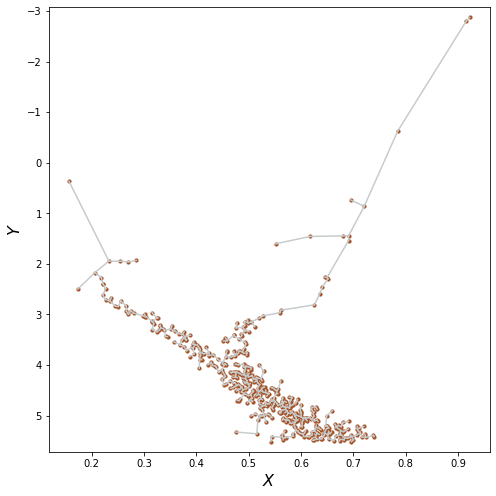

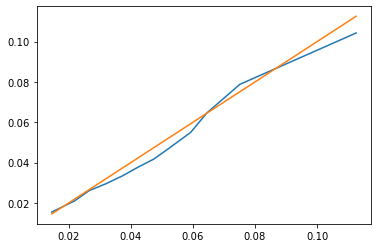

In [8]:
def mix_CMDs_proportional(CMD0, CMD1, alpha):
    mixed_CMD = mix_CMDs([CMD0, CMD1], [int(np.round(500*alpha)), int(np.round((1-alpha)*500))])
    return mixed_CMD

def plotMST(CMD):
    y = CMD.iloc[:,0].to_numpy()
    x = CMD.iloc[:,1].to_numpy()
    mst = mist.GetMST(x=sta(x), y=sta(y))
    d, l, b, s, l_index, b_index = mst.get_stats(include_index=True)

    plt.figure(figsize=(7., 7.))
    plt.plot([x[l_index[0]], x[l_index[1]]],
             [y[l_index[0]], y[l_index[1]]],
             color='#C6CBCE')
    plt.scatter(x, y, s=10, color='#A55225')
    plt.ylim([y.max()+0.2, y.min()-0.2])
    plt.xlabel("B-V")
    plt.ylabel("V")
    plt.xlabel(r'$X$', size=16)
    plt.ylabel(r'$Y$', size=16)
    plt.tight_layout()
    plt.show()
    return(l)

    
pure = mix_CMDs_proportional('isochrones/cmd_synt.13000.Fe-1.0.dat', 'isochrones/cmd_synt.3000.Fe-1.0.dat', 1.0)
halfnhalf = mix_CMDs_proportional('isochrones/cmd_synt.13000.Fe-1.0.dat', 'isochrones/cmd_synt.3000.Fe-1.0.dat', 0.5)
plotCMD(pure)
plt.show()

lpure = plotMST(pure)
plt.show()

plotCMD(halfnhalf)
plt.show()

lhalfnhalf = plotMST(halfnhalf)
plt.show()

nquantiles = 12
qs = (1+np.arange(nquantiles))/(nquantiles+1)
plt.plot(np.quantile(lpure, qs), np.quantile(lhalfnhalf, qs))
plt.plot(np.quantile(lpure, qs), np.quantile(lpure, qs))
plt.show()

It seems that the quantiles of the MST edge length are not that different in the two cases :-(

In [158]:
def MST_of_a_mix(CMD0, CMD1, alpha, nquantiles=8):
    thismix = mix_CMDs_proportional(CMD0, CMD1, alpha)
    mst = mist.GetMST(x=sta(thismix.iloc[:,0].to_numpy()), y=sta(thismix.iloc[:,1].to_numpy()))
    d, l, b, s = mst.get_stats()
    lq = np.quantile(l, (1+np.arange(nquantiles))/(nquantiles+1)) 
    lq = lq/lq[int(nquantiles/2)] #normalize to the median
    return(lq)

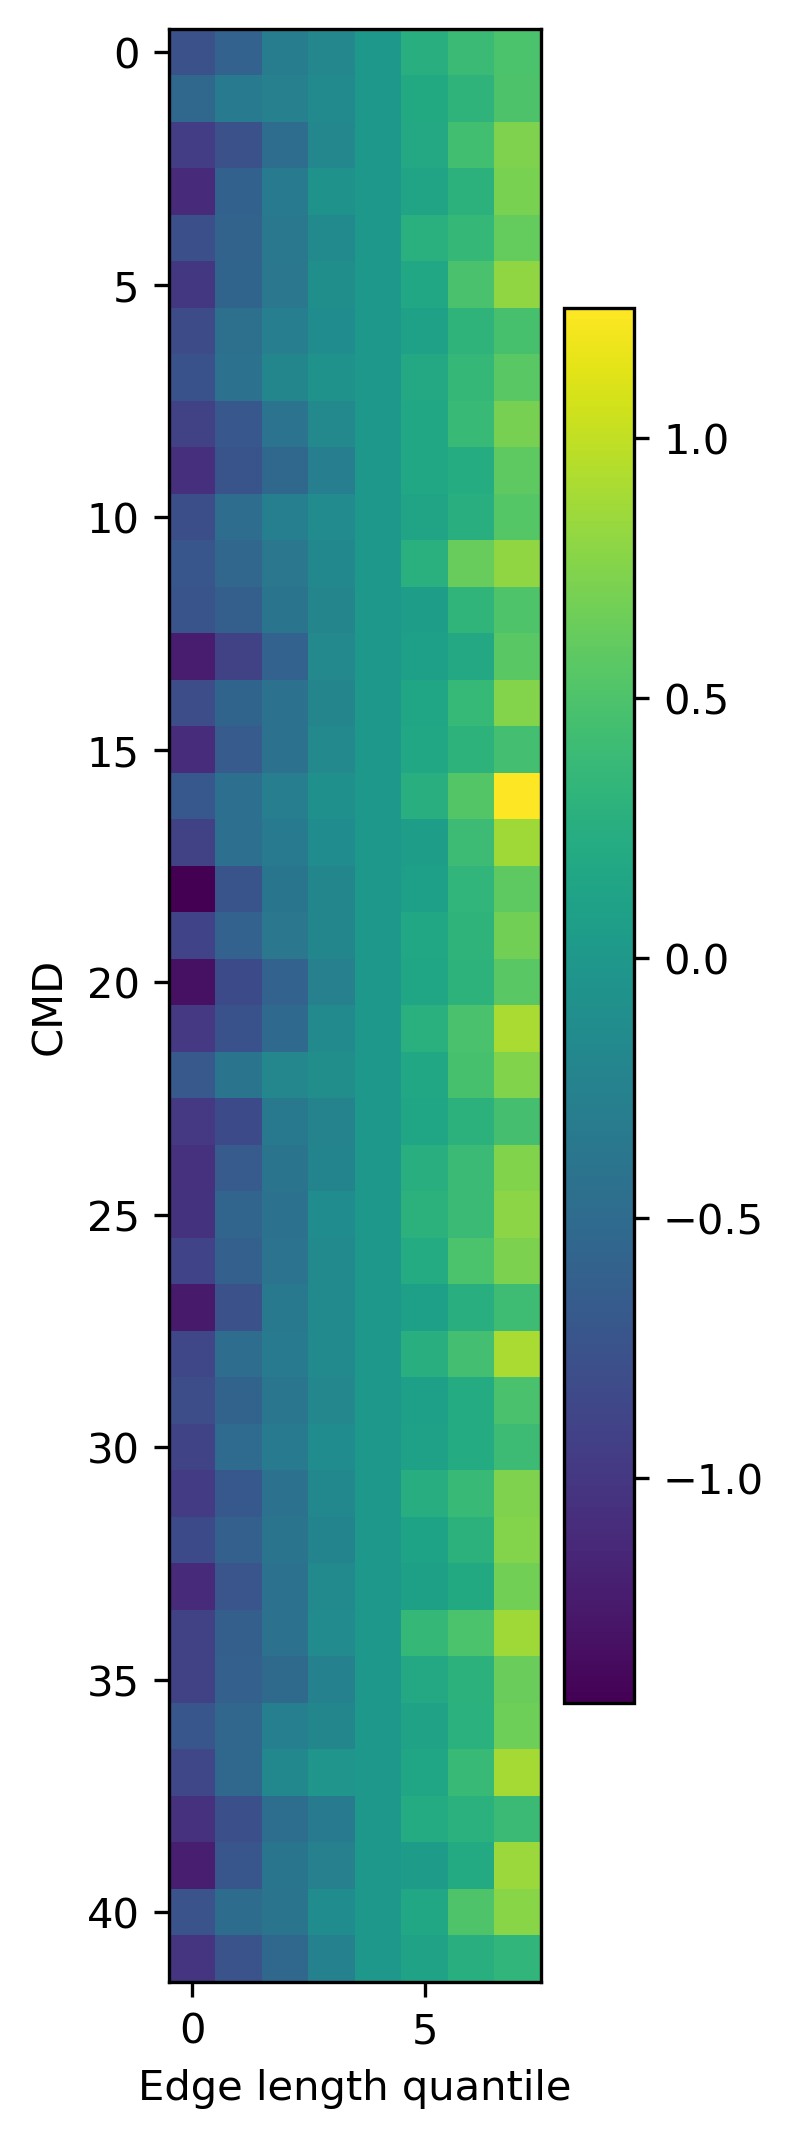

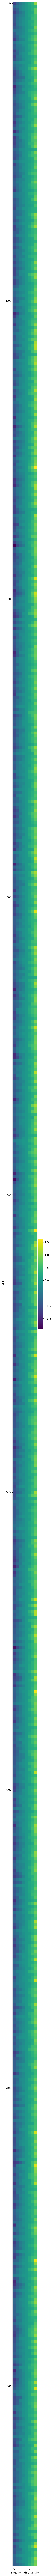

In [128]:
import os
CMDs = os.listdir('isochrones')

pure_MSTs = []
for CMD in CMDs:
    pure_MSTs.append(MST_of_a_mix('isochrones/' + CMD, 'isochrones/' + CMD, 1.0))

impure_MSTs = []
for i in range(len(CMDs)):
    for j in range(i):
        impure_MSTs.append(MST_of_a_mix('isochrones/' + CMDs[i], 'isochrones/' + CMDs[j], 0.5))

plt.figure(figsize=(2, 80), dpi=300)    
plt.imshow(np.log(np.array(pure_MSTs)))
plt.xlabel("Edge length quantile")
plt.ylabel("CMD")
plt.colorbar()
plt.show()

plt.figure(figsize=(2, 200), dpi=300)    
plt.imshow(np.log(np.array(impure_MSTs)))
plt.xlabel("Edge length quantile")
plt.ylabel("CMD")
plt.colorbar()
plt.show()

In [137]:
impure_MSTs = np.array(impure_MSTs)
pure_MSTs = np.array(pure_MSTs)
sub_impure_MSTs = impure_MSTs[np.random.choice(range(impure_MSTs.shape[0]), pure_MSTs.shape[0]),:]
features = np.concatenate([pure_MSTs, sub_impure_MSTs], axis=0)
labels = np.zeros(features.shape[0], dtype=bool)
labels[0:len(pure_MSTs)] = True
features.shape

(84, 8)

In [143]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
svm = SVC(random_state = 4)
svm_performance = cross_val_score(svm, features, labels, cv = 10, scoring='f1')
tree = RandomForestClassifier(random_state = 4)
tree_performance = cross_val_score(tree, features, labels, cv = 10, scoring='f1')

print(svm_performance.mean())
print(tree_performance.mean())

0.6479942279942279
0.6041630591630591


Wow, terrible performance. I wonder why?